In [1]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available ? :  True


In [2]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

DeepCTR version 0.8.3 detected. Your version is 0.8.2.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.8.3


In [3]:
data = pd.read_csv('../../../../ipr/data/tb_ipr_m_seamless_2nd_movie_20201118.csv')

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [9]:
data = data[['sa_id', 'album_id']]

In [10]:
data['sa_id'] = data['sa_id'].apply(lambda x: str(x))
data['album_id'] = data['album_id'].apply(lambda x: str(x))

In [11]:
sparse_features = ['sa_id', 'album_id',
#                    'buy_seg'
                  ]
# dense_features = ['release_date', 'run_time', 'movie_meta_price', 'i30_meta_price', 'buy_tot',
#                   'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4']
target = ['label']

### label encoding

In [12]:
lbe_dict = {}

In [16]:
# with open('../../model/said_albumid_onlineNegative/case1_re3/lbe_dict.pickle', 'rb') as f:
#     lbe_dict = pickle.load(f)

In [9]:
if len(lbe_dict) != 0:
    for feat in sparse_features:
        lbe = lbe_dict[feat]
        data[feat] = lbe.transform(data[feat])
else:
    for feat in sparse_features:
        print(feat)
        lbe = LabelEncoder()
        lbe.fit(data[feat])
        data[feat] = lbe.transform(data[feat])
        lbe_dict[feat] = lbe

sa_id
album_id


In [11]:
with open('./lbe_dict.pickle', 'wb') as f:
    pickle.dump(lbe_dict, f)

In [12]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [14]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
# train_model_input = {name:train[name] for name in feature_names}
# test_model_input = {name:test[name] for name in feature_names}

In [15]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['AUC'], )

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### negative sampling

In [18]:
user_col = ['sa_id']
cont_col = ['album_id']
user_tab = data[user_col]
cont_tab = data[cont_col]
user_uni_tab = user_tab.loc[list(user_tab['sa_id'].drop_duplicates().index)]
cont_uni_tab = cont_tab.loc[list(cont_tab['album_id'].drop_duplicates().index)]

album_id_list = list(cont_uni_tab['album_id'])

In [19]:
user_uni_tab

,sa_id
0,0
1,7
2,41
3,42
4,43
...,...
7658348,1274621
7658349,1274639
7658352,1274712
7658356,1274810


In [20]:
cont_uni_tab

,album_id
0,10998
1,7225
2,2079
3,7749
4,6720
...,...
7548183,6612
7558123,5066
7562741,8939
7568133,11512


In [25]:
# tmp = time.time()
# data_dict = data.set_index(keys=['sa_id', 'album_id']).T.to_dict('list')
# print(time.time() - tmp)

2517.4873881340027


In [ ]:
tmp = time.time()
train_dict = train.set_index(keys=['sa_id', 'album_id']).T.to_dict('list')
test_dict = test.set_index(keys=['sa_id', 'album_id']).T.to_dict('list')
print(time.time() - tmp)

In [41]:
len(train_dict)

11579312

In [42]:
len(test_dict)

2894828

In [43]:
def get_train_instances(train, num_negatives, album_id_list):
    user_input, item_input, labels = [],[],[]
    
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = random.randint(0, len(album_id_list) - 1)
            album = album_id_list[j]
            while (u, album) in train.keys() :
                j = random.randint(0, len(album_id_list) - 1)
                album = album_id_list[j]
            user_input.append(u)
            item_input.append(album)
            labels.append(0)
    return user_input, item_input, labels

In [33]:
num_epochs = 10
num_negatives = 1

In [44]:
test_user_input, test_item_input, test_labels = get_train_instances(test_dict, num_negatives, album_id_list)

In [49]:
[np.array(test_user_input), np.array(test_item_input), np.array(test_labels)]

[array([596459, 596459, 451613, ..., 220147, 138940, 138940]),
 array([10834,  8061,  3538, ...,  8764,  7592,  4107]),
 array([1, 0, 1, ..., 0, 1, 0])]

* 210111 10x10 train_dict, test_dictr

In [50]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(train_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)

#     break
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**15, epochs=10, verbose=1,
#                      validation_split=0.2,
                     validation_data=([np.array(test_user_input), np.array(test_item_input)],
                                     np.array(test_labels)),
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


707/707 [==============================] - 16s 23ms/step - loss: 0.3399 - auc: 0.9326 - val_loss: 0.3016 - val_auc: 0.9475
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2918 - auc: 0.9520 - val_loss: 0.2918 - val_auc: 0.9523
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2755 - auc: 0.9585 - val_loss: 0.2882 - val_auc: 0.9549
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2635 - auc: 0.9636 - val_loss: 0.2885 - val_auc: 0.9563
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2537 - auc: 0.9675 - val_loss: 0.2917 - val_auc: 0.9564
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2458 - auc: 0.9704 - val_loss: 0.2950 - val_auc: 0.9562
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2402 - auc: 0.9722 - val_loss: 0.2982 - val_auc: 0.9558
Epoch 8/10
707/707 [==============================] - 15s 22ms/step - los


 10%|█         | 1/10 [03:17<29:34, 197.20s/it]

Epoch 1/10
707/707 [==============================] - 16s 22ms/step - loss: 0.2624 - auc: 0.9645 - val_loss: 0.2890 - val_auc: 0.9587
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2399 - auc: 0.9710 - val_loss: 0.2938 - val_auc: 0.9575
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2329 - auc: 0.9733 - val_loss: 0.2979 - val_auc: 0.9566
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2299 - auc: 0.9744 - val_loss: 0.3008 - val_auc: 0.9559
Epoch 5/10
707/707 [==============================] - 16s 22ms/step - loss: 0.2280 - auc: 0.9750 - val_loss: 0.3028 - val_auc: 0.9554
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2267 - auc: 0.9755 - val_loss: 0.3053 - val_auc: 0.9551
Epoch 7/10
707/707 [==============================] - 16s 22ms/step - loss: 0.2257 - auc: 0.9758 - val_loss: 0.3073 - val_auc: 0.9550
Epoch 8/10
707/707 [==============================] - 15s 22ms


 20%|██        | 2/10 [06:31<26:11, 196.47s/it]

Epoch 1/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2594 - auc: 0.9656 - val_loss: 0.2930 - val_auc: 0.9589
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2372 - auc: 0.9720 - val_loss: 0.2964 - val_auc: 0.9573
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2295 - auc: 0.9740 - val_loss: 0.2985 - val_auc: 0.9563
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2269 - auc: 0.9749 - val_loss: 0.3016 - val_auc: 0.9559
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2252 - auc: 0.9755 - val_loss: 0.3040 - val_auc: 0.9554
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2243 - auc: 0.9759 - val_loss: 0.3054 - val_auc: 0.9552
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2236 - auc: 0.9761 - val_loss: 0.3076 - val_auc: 0.9548
Epoch 8/10
707/707 [==============================] - 15s 22ms


 30%|███       | 3/10 [09:46<22:51, 195.88s/it]

Epoch 1/10
707/707 [==============================] - 16s 23ms/step - loss: 0.2580 - auc: 0.9661 - val_loss: 0.2932 - val_auc: 0.9590
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2359 - auc: 0.9724 - val_loss: 0.2986 - val_auc: 0.9571
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2278 - auc: 0.9745 - val_loss: 0.3031 - val_auc: 0.9556
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2256 - auc: 0.9752 - val_loss: 0.3031 - val_auc: 0.9557
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2241 - auc: 0.9758 - val_loss: 0.3056 - val_auc: 0.9551
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2231 - auc: 0.9761 - val_loss: 0.3075 - val_auc: 0.9549
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2224 - auc: 0.9764 - val_loss: 0.3094 - val_auc: 0.9546
Epoch 8/10
707/707 [==============================] - 15s 22ms


 40%|████      | 4/10 [13:01<19:34, 195.72s/it]

Epoch 1/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2576 - auc: 0.9662 - val_loss: 0.2939 - val_auc: 0.9590
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2356 - auc: 0.9725 - val_loss: 0.2991 - val_auc: 0.9568
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2274 - auc: 0.9746 - val_loss: 0.3055 - val_auc: 0.9554
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2251 - auc: 0.9754 - val_loss: 0.3059 - val_auc: 0.9552
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2238 - auc: 0.9759 - val_loss: 0.3080 - val_auc: 0.9549
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2227 - auc: 0.9763 - val_loss: 0.3103 - val_auc: 0.9548
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2220 - auc: 0.9766 - val_loss: 0.3113 - val_auc: 0.9544
Epoch 8/10
707/707 [==============================] - 15s 22ms


 50%|█████     | 5/10 [16:16<16:16, 195.38s/it]

Epoch 1/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2576 - auc: 0.9663 - val_loss: 0.2943 - val_auc: 0.9589
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2356 - auc: 0.9726 - val_loss: 0.3000 - val_auc: 0.9568
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2272 - auc: 0.9747 - val_loss: 0.3061 - val_auc: 0.9554
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2250 - auc: 0.9754 - val_loss: 0.3090 - val_auc: 0.9545
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2236 - auc: 0.9760 - val_loss: 0.3105 - val_auc: 0.9545
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2226 - auc: 0.9763 - val_loss: 0.3122 - val_auc: 0.9544
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2219 - auc: 0.9766 - val_loss: 0.3145 - val_auc: 0.9540
Epoch 8/10
707/707 [==============================] - 15s 22ms


 60%|██████    | 6/10 [19:31<13:00, 195.19s/it]

Epoch 1/10
707/707 [==============================] - 16s 22ms/step - loss: 0.2577 - auc: 0.9663 - val_loss: 0.2946 - val_auc: 0.9590
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2353 - auc: 0.9727 - val_loss: 0.3019 - val_auc: 0.9567
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2271 - auc: 0.9748 - val_loss: 0.3076 - val_auc: 0.9552
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2248 - auc: 0.9755 - val_loss: 0.3096 - val_auc: 0.9547
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2235 - auc: 0.9760 - val_loss: 0.3109 - val_auc: 0.9545
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2227 - auc: 0.9764 - val_loss: 0.3138 - val_auc: 0.9540
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2219 - auc: 0.9767 - val_loss: 0.3150 - val_auc: 0.9541
Epoch 8/10
707/707 [==============================] - 15s 22ms


 70%|███████   | 7/10 [22:45<09:44, 194.94s/it]

Epoch 1/10
707/707 [==============================] - 16s 23ms/step - loss: 0.2579 - auc: 0.9664 - val_loss: 0.2962 - val_auc: 0.9589
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2355 - auc: 0.9727 - val_loss: 0.3030 - val_auc: 0.9565
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2272 - auc: 0.9748 - val_loss: 0.3101 - val_auc: 0.9549
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2249 - auc: 0.9755 - val_loss: 0.3125 - val_auc: 0.9545
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2236 - auc: 0.9760 - val_loss: 0.3119 - val_auc: 0.9546
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2227 - auc: 0.9764 - val_loss: 0.3152 - val_auc: 0.9541
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2221 - auc: 0.9767 - val_loss: 0.3163 - val_auc: 0.9539
Epoch 8/10
707/707 [==============================] - 15s 22ms


 80%|████████  | 8/10 [26:00<06:29, 194.83s/it]

Epoch 1/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2582 - auc: 0.9663 - val_loss: 0.2971 - val_auc: 0.9589
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2359 - auc: 0.9727 - val_loss: 0.3025 - val_auc: 0.9566
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2277 - auc: 0.9748 - val_loss: 0.3131 - val_auc: 0.9546
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2253 - auc: 0.9755 - val_loss: 0.3137 - val_auc: 0.9544
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2241 - auc: 0.9760 - val_loss: 0.3157 - val_auc: 0.9540
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2231 - auc: 0.9764 - val_loss: 0.3175 - val_auc: 0.9537
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2224 - auc: 0.9767 - val_loss: 0.3206 - val_auc: 0.9533
Epoch 8/10
707/707 [==============================] - 15s 22ms


 90%|█████████ | 9/10 [29:14<03:14, 194.58s/it]

Epoch 1/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2585 - auc: 0.9663 - val_loss: 0.2969 - val_auc: 0.9589
Epoch 2/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2362 - auc: 0.9727 - val_loss: 0.3058 - val_auc: 0.9561
Epoch 3/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2279 - auc: 0.9748 - val_loss: 0.3109 - val_auc: 0.9549
Epoch 4/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2255 - auc: 0.9755 - val_loss: 0.3158 - val_auc: 0.9542
Epoch 5/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2243 - auc: 0.9760 - val_loss: 0.3167 - val_auc: 0.9539
Epoch 6/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2232 - auc: 0.9764 - val_loss: 0.3169 - val_auc: 0.9536
Epoch 7/10
707/707 [==============================] - 15s 22ms/step - loss: 0.2226 - auc: 0.9766 - val_loss: 0.3183 - val_auc: 0.9537
Epoch 8/10
707/707 [==============================] - 15s 22ms


100%|██████████| 10/10 [32:29<00:00, 194.90s/it]


In [51]:
filepath = '../../model/said_albumid_onlineNegative/case1_re5/{0:02d}_epochs_{1:02d}_negative'.format(num_epochs, num_negatives)
model.save(filepath=filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re5/10_epochs_01_negative/assets


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re5/10_epochs_01_negative/assets


* 210108 10epochs

In [27]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)

#     break
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18/18 [==============================] - 2s 123ms/step - loss: 0.6865 - auc: 0.8303 - val_loss: 0.6731 - val_auc: 0.9047


 10%|█         | 1/10 [00:43<06:34, 43.79s/it]

18/18 [==============================] - 2s 135ms/step - loss: 0.6433 - auc: 0.8860 - val_loss: 0.5928 - val_auc: 0.9081


 20%|██        | 2/10 [01:26<05:47, 43.42s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.5243 - auc: 0.8916 - val_loss: 0.4391 - val_auc: 0.9287


 30%|███       | 3/10 [02:08<05:00, 42.95s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3860 - auc: 0.9109 - val_loss: 0.3472 - val_auc: 0.9357


 40%|████      | 4/10 [02:50<04:16, 42.70s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.3356 - auc: 0.9325 - val_loss: 0.3274 - val_auc: 0.9370


 50%|█████     | 5/10 [03:32<03:32, 42.59s/it]

18/18 [==============================] - 3s 139ms/step - loss: 0.3234 - auc: 0.9374 - val_loss: 0.3200 - val_auc: 0.9383


 60%|██████    | 6/10 [04:15<02:50, 42.62s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.3150 - auc: 0.9397 - val_loss: 0.3137 - val_auc: 0.9399


 70%|███████   | 7/10 [04:57<02:07, 42.36s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.3077 - auc: 0.9418 - val_loss: 0.3098 - val_auc: 0.9414


 80%|████████  | 8/10 [05:38<01:24, 42.21s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3007 - auc: 0.9444 - val_loss: 0.3062 - val_auc: 0.9433


 90%|█████████ | 9/10 [06:21<00:42, 42.16s/it]

18/18 [==============================] - 3s 140ms/step - loss: 0.2935 - auc: 0.9472 - val_loss: 0.3036 - val_auc: 0.9446


100%|██████████| 10/10 [07:03<00:00, 42.40s/it]


In [28]:
filepath = '../../model/said_albumid_onlineNegative/case1_re4/{0:02d}_epochs_{1:02d}_negative'.format(num_epochs, num_negatives)
model.save(filepath=filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re4/10_epochs_01_negative/assets


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re4/10_epochs_01_negative/assets


* 210108 100epochs

In [36]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)

#     break
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18/18 [==============================] - 2s 124ms/step - loss: 0.6864 - auc: 0.8188 - val_loss: 0.6720 - val_auc: 0.8985


  1%|          | 1/100 [00:43<1:11:11, 43.14s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.6397 - auc: 0.8856 - val_loss: 0.5840 - val_auc: 0.9096


  2%|▏         | 2/100 [01:23<1:09:15, 42.40s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.5090 - auc: 0.8923 - val_loss: 0.4198 - val_auc: 0.9258


  3%|▎         | 3/100 [02:04<1:07:51, 41.97s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3717 - auc: 0.9141 - val_loss: 0.3399 - val_auc: 0.9355


  4%|▍         | 4/100 [02:45<1:06:45, 41.72s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3322 - auc: 0.9338 - val_loss: 0.3260 - val_auc: 0.9368


  5%|▌         | 5/100 [03:26<1:05:42, 41.50s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3219 - auc: 0.9376 - val_loss: 0.3183 - val_auc: 0.9386


  6%|▌         | 6/100 [04:07<1:04:40, 41.28s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.3141 - auc: 0.9398 - val_loss: 0.3132 - val_auc: 0.9400


  7%|▋         | 7/100 [04:48<1:03:45, 41.14s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.3072 - auc: 0.9420 - val_loss: 0.3091 - val_auc: 0.9417


  8%|▊         | 8/100 [05:29<1:02:59, 41.09s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2997 - auc: 0.9448 - val_loss: 0.3054 - val_auc: 0.9436


  9%|▉         | 9/100 [06:10<1:02:15, 41.05s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2928 - auc: 0.9474 - val_loss: 0.3031 - val_auc: 0.9446


 10%|█         | 10/100 [06:51<1:01:26, 40.96s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2867 - auc: 0.9492 - val_loss: 0.3021 - val_auc: 0.9453


 11%|█         | 11/100 [07:32<1:00:50, 41.02s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2815 - auc: 0.9511 - val_loss: 0.3001 - val_auc: 0.9467


 12%|█▏        | 12/100 [08:13<1:00:07, 40.99s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2769 - auc: 0.9528 - val_loss: 0.2978 - val_auc: 0.9478


 13%|█▎        | 13/100 [08:54<59:30, 41.04s/it]  

18/18 [==============================] - 2s 105ms/step - loss: 0.2735 - auc: 0.9539 - val_loss: 0.2966 - val_auc: 0.9484


 14%|█▍        | 14/100 [09:35<58:44, 40.98s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2706 - auc: 0.9547 - val_loss: 0.2955 - val_auc: 0.9489


 15%|█▌        | 15/100 [10:16<58:10, 41.06s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2683 - auc: 0.9554 - val_loss: 0.2952 - val_auc: 0.9491


 16%|█▌        | 16/100 [10:57<57:30, 41.08s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2666 - auc: 0.9559 - val_loss: 0.2946 - val_auc: 0.9494


 17%|█▋        | 17/100 [11:38<56:45, 41.03s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2650 - auc: 0.9562 - val_loss: 0.2945 - val_auc: 0.9495


 18%|█▊        | 18/100 [12:19<56:04, 41.03s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2631 - auc: 0.9567 - val_loss: 0.2948 - val_auc: 0.9496


 19%|█▉        | 19/100 [13:00<55:23, 41.03s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2613 - auc: 0.9572 - val_loss: 0.2944 - val_auc: 0.9498


 20%|██        | 20/100 [13:41<54:43, 41.05s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2595 - auc: 0.9576 - val_loss: 0.2946 - val_auc: 0.9498


 21%|██        | 21/100 [14:22<54:07, 41.11s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2580 - auc: 0.9579 - val_loss: 0.2944 - val_auc: 0.9499


 22%|██▏       | 22/100 [15:03<53:24, 41.08s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2561 - auc: 0.9585 - val_loss: 0.2940 - val_auc: 0.9501


 23%|██▎       | 23/100 [15:44<52:37, 41.01s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2541 - auc: 0.9590 - val_loss: 0.2936 - val_auc: 0.9504


 24%|██▍       | 24/100 [16:25<51:58, 41.04s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2519 - auc: 0.9596 - val_loss: 0.2931 - val_auc: 0.9507


 25%|██▌       | 25/100 [17:06<51:11, 40.95s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2495 - auc: 0.9604 - val_loss: 0.2922 - val_auc: 0.9512


 26%|██▌       | 26/100 [17:47<50:35, 41.01s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2473 - auc: 0.9610 - val_loss: 0.2922 - val_auc: 0.9514


 27%|██▋       | 27/100 [18:28<49:55, 41.04s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2445 - auc: 0.9618 - val_loss: 0.2920 - val_auc: 0.9518


 28%|██▊       | 28/100 [19:10<49:21, 41.13s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2423 - auc: 0.9625 - val_loss: 0.2917 - val_auc: 0.9522


 29%|██▉       | 29/100 [19:51<48:40, 41.14s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2398 - auc: 0.9633 - val_loss: 0.2924 - val_auc: 0.9522


 30%|███       | 30/100 [20:32<48:02, 41.17s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2378 - auc: 0.9638 - val_loss: 0.2929 - val_auc: 0.9525


 31%|███       | 31/100 [21:13<47:14, 41.08s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2359 - auc: 0.9644 - val_loss: 0.2938 - val_auc: 0.9526


 32%|███▏      | 32/100 [21:54<46:30, 41.04s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2338 - auc: 0.9650 - val_loss: 0.2946 - val_auc: 0.9527


 33%|███▎      | 33/100 [22:35<45:48, 41.02s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2316 - auc: 0.9657 - val_loss: 0.2951 - val_auc: 0.9529


 34%|███▍      | 34/100 [23:16<45:09, 41.05s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2301 - auc: 0.9661 - val_loss: 0.2955 - val_auc: 0.9531


 35%|███▌      | 35/100 [23:57<44:29, 41.07s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2283 - auc: 0.9667 - val_loss: 0.2965 - val_auc: 0.9532


 36%|███▌      | 36/100 [24:38<43:49, 41.08s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2267 - auc: 0.9672 - val_loss: 0.2983 - val_auc: 0.9530


 37%|███▋      | 37/100 [25:19<43:04, 41.02s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2253 - auc: 0.9676 - val_loss: 0.2986 - val_auc: 0.9532


 38%|███▊      | 38/100 [26:00<42:20, 40.98s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2238 - auc: 0.9680 - val_loss: 0.2995 - val_auc: 0.9533


 39%|███▉      | 39/100 [26:41<41:41, 41.01s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2224 - auc: 0.9684 - val_loss: 0.3002 - val_auc: 0.9534


 40%|████      | 40/100 [27:22<40:58, 40.98s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2212 - auc: 0.9688 - val_loss: 0.3010 - val_auc: 0.9533


 41%|████      | 41/100 [28:03<40:14, 40.93s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2201 - auc: 0.9691 - val_loss: 0.3012 - val_auc: 0.9535


 42%|████▏     | 42/100 [28:44<39:29, 40.85s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2191 - auc: 0.9693 - val_loss: 0.3016 - val_auc: 0.9536


 43%|████▎     | 43/100 [29:24<38:48, 40.86s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2180 - auc: 0.9697 - val_loss: 0.3022 - val_auc: 0.9536


 44%|████▍     | 44/100 [30:05<38:09, 40.88s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2167 - auc: 0.9700 - val_loss: 0.3035 - val_auc: 0.9536


 45%|████▌     | 45/100 [30:46<37:28, 40.88s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2157 - auc: 0.9703 - val_loss: 0.3048 - val_auc: 0.9535


 46%|████▌     | 46/100 [31:27<36:53, 41.00s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2149 - auc: 0.9705 - val_loss: 0.3056 - val_auc: 0.9535


 47%|████▋     | 47/100 [32:09<36:17, 41.09s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2139 - auc: 0.9708 - val_loss: 0.3057 - val_auc: 0.9535


 48%|████▊     | 48/100 [32:50<35:42, 41.21s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2131 - auc: 0.9710 - val_loss: 0.3060 - val_auc: 0.9536


 49%|████▉     | 49/100 [33:31<35:01, 41.21s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2122 - auc: 0.9712 - val_loss: 0.3074 - val_auc: 0.9535


 50%|█████     | 50/100 [34:13<34:19, 41.19s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2112 - auc: 0.9715 - val_loss: 0.3081 - val_auc: 0.9535


 51%|█████     | 51/100 [34:54<33:36, 41.15s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2104 - auc: 0.9717 - val_loss: 0.3091 - val_auc: 0.9533


 52%|█████▏    | 52/100 [35:35<32:56, 41.18s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2097 - auc: 0.9718 - val_loss: 0.3100 - val_auc: 0.9534


 53%|█████▎    | 53/100 [36:16<32:13, 41.14s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2088 - auc: 0.9720 - val_loss: 0.3105 - val_auc: 0.9534


 54%|█████▍    | 54/100 [36:57<31:33, 41.17s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2082 - auc: 0.9722 - val_loss: 0.3116 - val_auc: 0.9533


 55%|█████▌    | 55/100 [37:38<30:50, 41.13s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2074 - auc: 0.9724 - val_loss: 0.3117 - val_auc: 0.9533


 56%|█████▌    | 56/100 [38:19<30:09, 41.13s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2067 - auc: 0.9725 - val_loss: 0.3124 - val_auc: 0.9534


 57%|█████▋    | 57/100 [39:00<29:26, 41.08s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2060 - auc: 0.9727 - val_loss: 0.3135 - val_auc: 0.9532


 58%|█████▊    | 58/100 [39:41<28:44, 41.05s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2055 - auc: 0.9727 - val_loss: 0.3133 - val_auc: 0.9534


 59%|█████▉    | 59/100 [40:22<28:03, 41.07s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2047 - auc: 0.9729 - val_loss: 0.3144 - val_auc: 0.9533


 60%|██████    | 60/100 [41:04<27:26, 41.15s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2041 - auc: 0.9731 - val_loss: 0.3155 - val_auc: 0.9532


 61%|██████    | 61/100 [41:45<26:44, 41.15s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2035 - auc: 0.9732 - val_loss: 0.3166 - val_auc: 0.9532


 62%|██████▏   | 62/100 [42:26<26:02, 41.11s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2028 - auc: 0.9733 - val_loss: 0.3170 - val_auc: 0.9532


 63%|██████▎   | 63/100 [43:07<25:20, 41.09s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2021 - auc: 0.9735 - val_loss: 0.3183 - val_auc: 0.9532


 64%|██████▍   | 64/100 [43:48<24:37, 41.04s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2015 - auc: 0.9736 - val_loss: 0.3180 - val_auc: 0.9533


 65%|██████▌   | 65/100 [44:29<23:55, 41.00s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2008 - auc: 0.9738 - val_loss: 0.3188 - val_auc: 0.9532


 66%|██████▌   | 66/100 [45:10<23:14, 41.02s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2002 - auc: 0.9739 - val_loss: 0.3193 - val_auc: 0.9533


 67%|██████▋   | 67/100 [45:51<22:35, 41.08s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1997 - auc: 0.9740 - val_loss: 0.3191 - val_auc: 0.9534


 68%|██████▊   | 68/100 [46:33<21:58, 41.20s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1989 - auc: 0.9742 - val_loss: 0.3205 - val_auc: 0.9533


 69%|██████▉   | 69/100 [47:14<21:18, 41.24s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1983 - auc: 0.9743 - val_loss: 0.3225 - val_auc: 0.9532


 70%|███████   | 70/100 [47:55<20:34, 41.14s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1975 - auc: 0.9745 - val_loss: 0.3220 - val_auc: 0.9533


 71%|███████   | 71/100 [48:36<19:51, 41.07s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.1972 - auc: 0.9745 - val_loss: 0.3212 - val_auc: 0.9535


 72%|███████▏  | 72/100 [49:17<19:10, 41.07s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1963 - auc: 0.9747 - val_loss: 0.3237 - val_auc: 0.9532


 73%|███████▎  | 73/100 [49:58<18:26, 41.00s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1955 - auc: 0.9749 - val_loss: 0.3244 - val_auc: 0.9534


 74%|███████▍  | 74/100 [50:38<17:44, 40.93s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1951 - auc: 0.9750 - val_loss: 0.3252 - val_auc: 0.9533


 75%|███████▌  | 75/100 [51:20<17:06, 41.06s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1944 - auc: 0.9751 - val_loss: 0.3254 - val_auc: 0.9534


 76%|███████▌  | 76/100 [52:01<16:27, 41.13s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1940 - auc: 0.9752 - val_loss: 0.3263 - val_auc: 0.9533


 77%|███████▋  | 77/100 [52:42<15:46, 41.14s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1936 - auc: 0.9753 - val_loss: 0.3280 - val_auc: 0.9532


 78%|███████▊  | 78/100 [53:23<15:02, 41.02s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1931 - auc: 0.9754 - val_loss: 0.3295 - val_auc: 0.9531


 79%|███████▉  | 79/100 [54:04<14:23, 41.11s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1925 - auc: 0.9755 - val_loss: 0.3300 - val_auc: 0.9531


 80%|████████  | 80/100 [54:46<13:43, 41.17s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1921 - auc: 0.9756 - val_loss: 0.3297 - val_auc: 0.9532


 81%|████████  | 81/100 [55:27<13:01, 41.11s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1915 - auc: 0.9757 - val_loss: 0.3306 - val_auc: 0.9533


 82%|████████▏ | 82/100 [56:08<12:19, 41.10s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1912 - auc: 0.9758 - val_loss: 0.3317 - val_auc: 0.9532


 83%|████████▎ | 83/100 [56:49<11:38, 41.07s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1912 - auc: 0.9758 - val_loss: 0.3323 - val_auc: 0.9531


 84%|████████▍ | 84/100 [57:30<10:58, 41.19s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1906 - auc: 0.9759 - val_loss: 0.3334 - val_auc: 0.9531


 85%|████████▌ | 85/100 [58:12<10:19, 41.29s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1902 - auc: 0.9760 - val_loss: 0.3358 - val_auc: 0.9529


 86%|████████▌ | 86/100 [58:53<09:37, 41.24s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1900 - auc: 0.9760 - val_loss: 0.3369 - val_auc: 0.9528


 87%|████████▋ | 87/100 [59:33<08:54, 41.09s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1895 - auc: 0.9761 - val_loss: 0.3372 - val_auc: 0.9528


 88%|████████▊ | 88/100 [1:00:14<08:12, 41.04s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1894 - auc: 0.9761 - val_loss: 0.3377 - val_auc: 0.9528


 89%|████████▉ | 89/100 [1:00:55<07:31, 41.04s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.1892 - auc: 0.9762 - val_loss: 0.3398 - val_auc: 0.9527


 90%|█████████ | 90/100 [1:01:36<06:50, 41.01s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1888 - auc: 0.9763 - val_loss: 0.3393 - val_auc: 0.9528


 91%|█████████ | 91/100 [1:02:18<06:09, 41.08s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1888 - auc: 0.9763 - val_loss: 0.3406 - val_auc: 0.9527


 92%|█████████▏| 92/100 [1:02:59<05:29, 41.14s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1882 - auc: 0.9764 - val_loss: 0.3416 - val_auc: 0.9525


 93%|█████████▎| 93/100 [1:03:40<04:48, 41.19s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1881 - auc: 0.9764 - val_loss: 0.3426 - val_auc: 0.9526


 94%|█████████▍| 94/100 [1:04:21<04:06, 41.11s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1877 - auc: 0.9765 - val_loss: 0.3440 - val_auc: 0.9525


 95%|█████████▌| 95/100 [1:05:02<03:25, 41.13s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1878 - auc: 0.9764 - val_loss: 0.3442 - val_auc: 0.9525


 96%|█████████▌| 96/100 [1:05:43<02:44, 41.10s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1876 - auc: 0.9765 - val_loss: 0.3455 - val_auc: 0.9524


 97%|█████████▋| 97/100 [1:06:25<02:03, 41.14s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1875 - auc: 0.9765 - val_loss: 0.3466 - val_auc: 0.9524


 98%|█████████▊| 98/100 [1:07:06<01:22, 41.16s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.1872 - auc: 0.9766 - val_loss: 0.3473 - val_auc: 0.9524


 99%|█████████▉| 99/100 [1:07:47<00:41, 41.20s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1874 - auc: 0.9765 - val_loss: 0.3479 - val_auc: 0.9523


100%|██████████| 100/100 [1:08:28<00:00, 41.08s/it]


In [37]:
filepath = '../../model/said_albumid_onlineNegative/case1_re3/{0:02d}_epochs_{1:02d}_negative'.format(num_epochs, num_negatives)
model.save(filepath=filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re3/100_epochs_01_negative/assets


INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re3/100_epochs_01_negative/assets


* 210106

In [35]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)

#     break
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)



  0%|          | 0/100 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18/18 [==============================] - 2s 124ms/step - loss: 0.6866 - auc: 0.8160 - val_loss: 0.6727 - val_auc: 0.9041




  1%|          | 1/100 [00:44<1:12:37, 44.01s/it]

18/18 [==============================] - 2s 103ms/step - loss: 0.6415 - auc: 0.8862 - val_loss: 0.5868 - val_auc: 0.9127




  2%|▏         | 2/100 [01:25<1:10:51, 43.38s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.5115 - auc: 0.8922 - val_loss: 0.4199 - val_auc: 0.9233




  3%|▎         | 3/100 [02:07<1:09:19, 42.88s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.3707 - auc: 0.9142 - val_loss: 0.3390 - val_auc: 0.9359




  4%|▍         | 4/100 [02:49<1:08:20, 42.71s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.3308 - auc: 0.9344 - val_loss: 0.3249 - val_auc: 0.9371




  5%|▌         | 5/100 [03:32<1:07:21, 42.54s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3206 - auc: 0.9380 - val_loss: 0.3166 - val_auc: 0.9392




  6%|▌         | 6/100 [04:13<1:06:10, 42.24s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.3125 - auc: 0.9403 - val_loss: 0.3125 - val_auc: 0.9402




  7%|▋         | 7/100 [04:55<1:05:17, 42.13s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.3055 - auc: 0.9425 - val_loss: 0.3084 - val_auc: 0.9420




  8%|▊         | 8/100 [05:37<1:04:26, 42.03s/it]

18/18 [==============================] - 2s 137ms/step - loss: 0.2985 - auc: 0.9453 - val_loss: 0.3055 - val_auc: 0.9436




  9%|▉         | 9/100 [06:19<1:03:53, 42.13s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2926 - auc: 0.9474 - val_loss: 0.3038 - val_auc: 0.9444




 10%|█         | 10/100 [07:01<1:03:09, 42.10s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2876 - auc: 0.9488 - val_loss: 0.3036 - val_auc: 0.9446




 11%|█         | 11/100 [07:43<1:02:11, 41.93s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2839 - auc: 0.9499 - val_loss: 0.3029 - val_auc: 0.9452




 12%|█▏        | 12/100 [08:25<1:01:28, 41.92s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2799 - auc: 0.9514 - val_loss: 0.3015 - val_auc: 0.9462




 13%|█▎        | 13/100 [09:07<1:00:56, 42.03s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2758 - auc: 0.9528 - val_loss: 0.2997 - val_auc: 0.9472




 14%|█▍        | 14/100 [09:49<1:00:04, 41.91s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2728 - auc: 0.9538 - val_loss: 0.2980 - val_auc: 0.9479




 15%|█▌        | 15/100 [10:30<59:19, 41.88s/it]  

18/18 [==============================] - 2s 105ms/step - loss: 0.2702 - auc: 0.9546 - val_loss: 0.2967 - val_auc: 0.9485




 16%|█▌        | 16/100 [11:12<58:35, 41.85s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2684 - auc: 0.9551 - val_loss: 0.2961 - val_auc: 0.9489




 17%|█▋        | 17/100 [11:55<58:06, 42.01s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2663 - auc: 0.9557 - val_loss: 0.2963 - val_auc: 0.9489




 18%|█▊        | 18/100 [12:36<57:14, 41.88s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2645 - auc: 0.9561 - val_loss: 0.2957 - val_auc: 0.9492




 19%|█▉        | 19/100 [13:18<56:24, 41.78s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2627 - auc: 0.9566 - val_loss: 0.2954 - val_auc: 0.9495




 20%|██        | 20/100 [13:59<55:35, 41.69s/it]

18/18 [==============================] - 3s 139ms/step - loss: 0.2611 - auc: 0.9570 - val_loss: 0.2954 - val_auc: 0.9496




 21%|██        | 21/100 [14:41<55:09, 41.89s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2595 - auc: 0.9574 - val_loss: 0.2960 - val_auc: 0.9494




 22%|██▏       | 22/100 [15:23<54:25, 41.87s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2582 - auc: 0.9577 - val_loss: 0.2958 - val_auc: 0.9496




 23%|██▎       | 23/100 [16:05<53:32, 41.72s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2569 - auc: 0.9580 - val_loss: 0.2957 - val_auc: 0.9497




 24%|██▍       | 24/100 [16:47<52:53, 41.76s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2555 - auc: 0.9584 - val_loss: 0.2959 - val_auc: 0.9498




 25%|██▌       | 25/100 [17:29<52:25, 41.94s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2540 - auc: 0.9589 - val_loss: 0.2950 - val_auc: 0.9501




 26%|██▌       | 26/100 [18:10<51:34, 41.81s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2527 - auc: 0.9592 - val_loss: 0.2954 - val_auc: 0.9502




 27%|██▋       | 27/100 [18:52<50:45, 41.71s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2510 - auc: 0.9597 - val_loss: 0.2950 - val_auc: 0.9504




 28%|██▊       | 28/100 [19:34<50:02, 41.71s/it]

18/18 [==============================] - 3s 139ms/step - loss: 0.2493 - auc: 0.9602 - val_loss: 0.2946 - val_auc: 0.9507




 29%|██▉       | 29/100 [20:16<49:42, 42.01s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2472 - auc: 0.9609 - val_loss: 0.2938 - val_auc: 0.9511




 30%|███       | 30/100 [20:58<48:59, 41.99s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2451 - auc: 0.9616 - val_loss: 0.2936 - val_auc: 0.9515




 31%|███       | 31/100 [21:40<48:19, 42.03s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2430 - auc: 0.9622 - val_loss: 0.2936 - val_auc: 0.9517




 32%|███▏      | 32/100 [22:23<47:40, 42.07s/it]

18/18 [==============================] - 2s 137ms/step - loss: 0.2408 - auc: 0.9629 - val_loss: 0.2946 - val_auc: 0.9518




 33%|███▎      | 33/100 [23:05<47:11, 42.26s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2388 - auc: 0.9635 - val_loss: 0.2947 - val_auc: 0.9521




 34%|███▍      | 34/100 [23:47<46:12, 42.01s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2370 - auc: 0.9640 - val_loss: 0.2958 - val_auc: 0.9521




 35%|███▌      | 35/100 [24:28<45:22, 41.88s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2355 - auc: 0.9644 - val_loss: 0.2969 - val_auc: 0.9521




 36%|███▌      | 36/100 [25:10<44:35, 41.81s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2340 - auc: 0.9648 - val_loss: 0.2982 - val_auc: 0.9520




 37%|███▋      | 37/100 [25:52<44:06, 42.00s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2332 - auc: 0.9650 - val_loss: 0.2986 - val_auc: 0.9522




 38%|███▊      | 38/100 [26:34<43:15, 41.86s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2320 - auc: 0.9653 - val_loss: 0.2993 - val_auc: 0.9522




 39%|███▉      | 39/100 [27:16<42:32, 41.84s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2311 - auc: 0.9656 - val_loss: 0.3003 - val_auc: 0.9521




 40%|████      | 40/100 [27:58<41:52, 41.88s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2303 - auc: 0.9658 - val_loss: 0.3007 - val_auc: 0.9522




 41%|████      | 41/100 [28:40<41:23, 42.09s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2293 - auc: 0.9660 - val_loss: 0.3010 - val_auc: 0.9523




 42%|████▏     | 42/100 [29:22<40:34, 41.97s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2285 - auc: 0.9662 - val_loss: 0.3019 - val_auc: 0.9523




 43%|████▎     | 43/100 [30:03<39:42, 41.80s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2278 - auc: 0.9664 - val_loss: 0.3023 - val_auc: 0.9522




 44%|████▍     | 44/100 [30:45<39:01, 41.82s/it]

18/18 [==============================] - 2s 139ms/step - loss: 0.2271 - auc: 0.9666 - val_loss: 0.3026 - val_auc: 0.9523




 45%|████▌     | 45/100 [31:28<38:30, 42.00s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2264 - auc: 0.9668 - val_loss: 0.3027 - val_auc: 0.9525




 46%|████▌     | 46/100 [32:10<37:50, 42.05s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2256 - auc: 0.9670 - val_loss: 0.3032 - val_auc: 0.9525




 47%|████▋     | 47/100 [32:52<37:07, 42.03s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2246 - auc: 0.9673 - val_loss: 0.3036 - val_auc: 0.9525




 48%|████▊     | 48/100 [33:34<36:25, 42.03s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2236 - auc: 0.9676 - val_loss: 0.3035 - val_auc: 0.9526




 49%|████▉     | 49/100 [34:16<35:46, 42.09s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2230 - auc: 0.9678 - val_loss: 0.3032 - val_auc: 0.9528




 50%|█████     | 50/100 [34:58<35:02, 42.05s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2218 - auc: 0.9681 - val_loss: 0.3039 - val_auc: 0.9528




 51%|█████     | 51/100 [35:40<34:16, 41.97s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2210 - auc: 0.9684 - val_loss: 0.3034 - val_auc: 0.9530




 52%|█████▏    | 52/100 [36:22<33:32, 41.94s/it]

18/18 [==============================] - 3s 139ms/step - loss: 0.2201 - auc: 0.9687 - val_loss: 0.3029 - val_auc: 0.9532




 53%|█████▎    | 53/100 [37:04<33:01, 42.17s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2189 - auc: 0.9690 - val_loss: 0.3036 - val_auc: 0.9532




 54%|█████▍    | 54/100 [37:46<32:14, 42.06s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2180 - auc: 0.9693 - val_loss: 0.3034 - val_auc: 0.9534




 55%|█████▌    | 55/100 [38:28<31:24, 41.88s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2169 - auc: 0.9696 - val_loss: 0.3038 - val_auc: 0.9534




 56%|█████▌    | 56/100 [39:09<30:42, 41.88s/it]

18/18 [==============================] - 3s 140ms/step - loss: 0.2159 - auc: 0.9699 - val_loss: 0.3032 - val_auc: 0.9538




 57%|█████▋    | 57/100 [39:52<30:08, 42.06s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2146 - auc: 0.9703 - val_loss: 0.3041 - val_auc: 0.9536




 58%|█████▊    | 58/100 [40:34<29:22, 41.96s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2136 - auc: 0.9705 - val_loss: 0.3045 - val_auc: 0.9537




 59%|█████▉    | 59/100 [41:15<28:38, 41.91s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2126 - auc: 0.9708 - val_loss: 0.3049 - val_auc: 0.9538




 60%|██████    | 60/100 [41:57<27:54, 41.86s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2118 - auc: 0.9710 - val_loss: 0.3055 - val_auc: 0.9538




 61%|██████    | 61/100 [42:39<27:14, 41.90s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2106 - auc: 0.9713 - val_loss: 0.3054 - val_auc: 0.9540




 62%|██████▏   | 62/100 [43:21<26:28, 41.79s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2096 - auc: 0.9716 - val_loss: 0.3061 - val_auc: 0.9540




 63%|██████▎   | 63/100 [44:03<25:47, 41.81s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2088 - auc: 0.9718 - val_loss: 0.3070 - val_auc: 0.9540




 64%|██████▍   | 64/100 [44:44<25:05, 41.82s/it]

18/18 [==============================] - 2s 138ms/step - loss: 0.2077 - auc: 0.9721 - val_loss: 0.3082 - val_auc: 0.9539




 65%|██████▌   | 65/100 [45:27<24:27, 41.94s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2067 - auc: 0.9724 - val_loss: 0.3084 - val_auc: 0.9541




 66%|██████▌   | 66/100 [46:08<23:40, 41.79s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2059 - auc: 0.9726 - val_loss: 0.3091 - val_auc: 0.9541




 67%|██████▋   | 67/100 [46:50<23:00, 41.82s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.2049 - auc: 0.9728 - val_loss: 0.3089 - val_auc: 0.9543




 68%|██████▊   | 68/100 [47:32<22:15, 41.74s/it]

18/18 [==============================] - 2s 137ms/step - loss: 0.2040 - auc: 0.9731 - val_loss: 0.3103 - val_auc: 0.9542




 69%|██████▉   | 69/100 [48:14<21:36, 41.83s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2034 - auc: 0.9732 - val_loss: 0.3109 - val_auc: 0.9542




 70%|███████   | 70/100 [48:55<20:50, 41.69s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2026 - auc: 0.9734 - val_loss: 0.3122 - val_auc: 0.9541




 71%|███████   | 71/100 [49:37<20:08, 41.67s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.2018 - auc: 0.9736 - val_loss: 0.3136 - val_auc: 0.9540




 72%|███████▏  | 72/100 [50:18<19:25, 41.64s/it]

18/18 [==============================] - 3s 140ms/step - loss: 0.2010 - auc: 0.9738 - val_loss: 0.3143 - val_auc: 0.9540




 73%|███████▎  | 73/100 [51:00<18:49, 41.82s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.2002 - auc: 0.9739 - val_loss: 0.3154 - val_auc: 0.9539




 74%|███████▍  | 74/100 [51:42<18:06, 41.80s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1999 - auc: 0.9740 - val_loss: 0.3161 - val_auc: 0.9539




 75%|███████▌  | 75/100 [52:24<17:23, 41.73s/it]

18/18 [==============================] - 2s 107ms/step - loss: 0.1993 - auc: 0.9741 - val_loss: 0.3175 - val_auc: 0.9537




 76%|███████▌  | 76/100 [53:05<16:38, 41.61s/it]

18/18 [==============================] - 3s 143ms/step - loss: 0.1989 - auc: 0.9742 - val_loss: 0.3185 - val_auc: 0.9536




 77%|███████▋  | 77/100 [53:47<15:59, 41.71s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1985 - auc: 0.9743 - val_loss: 0.3198 - val_auc: 0.9536




 78%|███████▊  | 78/100 [54:28<15:16, 41.64s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1977 - auc: 0.9745 - val_loss: 0.3212 - val_auc: 0.9534




 79%|███████▉  | 79/100 [55:10<14:34, 41.63s/it]

18/18 [==============================] - 2s 108ms/step - loss: 0.1972 - auc: 0.9746 - val_loss: 0.3232 - val_auc: 0.9533




 80%|████████  | 80/100 [55:52<13:54, 41.70s/it]

18/18 [==============================] - 3s 141ms/step - loss: 0.1966 - auc: 0.9747 - val_loss: 0.3240 - val_auc: 0.9531




 81%|████████  | 81/100 [56:34<13:13, 41.78s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1965 - auc: 0.9748 - val_loss: 0.3253 - val_auc: 0.9531




 82%|████████▏ | 82/100 [57:15<12:27, 41.55s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.1960 - auc: 0.9749 - val_loss: 0.3270 - val_auc: 0.9530




 83%|████████▎ | 83/100 [57:57<11:47, 41.60s/it]

18/18 [==============================] - 2s 107ms/step - loss: 0.1957 - auc: 0.9750 - val_loss: 0.3282 - val_auc: 0.9529




 84%|████████▍ | 84/100 [58:38<11:05, 41.60s/it]

18/18 [==============================] - 3s 142ms/step - loss: 0.1953 - auc: 0.9751 - val_loss: 0.3309 - val_auc: 0.9526




 85%|████████▌ | 85/100 [59:20<10:25, 41.71s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1949 - auc: 0.9751 - val_loss: 0.3310 - val_auc: 0.9526




 86%|████████▌ | 86/100 [1:00:01<09:41, 41.55s/it]

18/18 [==============================] - 2s 104ms/step - loss: 0.1947 - auc: 0.9752 - val_loss: 0.3321 - val_auc: 0.9525




 87%|████████▋ | 87/100 [1:00:43<09:00, 41.56s/it]

18/18 [==============================] - 2s 107ms/step - loss: 0.1945 - auc: 0.9752 - val_loss: 0.3331 - val_auc: 0.9525




 88%|████████▊ | 88/100 [1:01:25<08:18, 41.57s/it]

18/18 [==============================] - 3s 143ms/step - loss: 0.1939 - auc: 0.9753 - val_loss: 0.3354 - val_auc: 0.9522




 89%|████████▉ | 89/100 [1:02:07<07:40, 41.82s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1939 - auc: 0.9754 - val_loss: 0.3368 - val_auc: 0.9523




 90%|█████████ | 90/100 [1:02:48<06:56, 41.67s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1934 - auc: 0.9755 - val_loss: 0.3379 - val_auc: 0.9521




 91%|█████████ | 91/100 [1:03:30<06:15, 41.75s/it]

18/18 [==============================] - 2s 108ms/step - loss: 0.1934 - auc: 0.9755 - val_loss: 0.3388 - val_auc: 0.9521




 92%|█████████▏| 92/100 [1:04:12<05:34, 41.81s/it]

18/18 [==============================] - 3s 141ms/step - loss: 0.1930 - auc: 0.9755 - val_loss: 0.3401 - val_auc: 0.9521




 93%|█████████▎| 93/100 [1:04:54<04:53, 41.87s/it]

18/18 [==============================] - 2s 106ms/step - loss: 0.1928 - auc: 0.9756 - val_loss: 0.3423 - val_auc: 0.9520




 94%|█████████▍| 94/100 [1:05:35<04:10, 41.70s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1923 - auc: 0.9757 - val_loss: 0.3435 - val_auc: 0.9518




 95%|█████████▌| 95/100 [1:06:17<03:28, 41.65s/it]

18/18 [==============================] - 2s 108ms/step - loss: 0.1923 - auc: 0.9757 - val_loss: 0.3445 - val_auc: 0.9516




 96%|█████████▌| 96/100 [1:06:59<02:46, 41.69s/it]

18/18 [==============================] - 3s 142ms/step - loss: 0.1921 - auc: 0.9757 - val_loss: 0.3442 - val_auc: 0.9517




 97%|█████████▋| 97/100 [1:07:41<02:05, 41.89s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1919 - auc: 0.9758 - val_loss: 0.3470 - val_auc: 0.9515




 98%|█████████▊| 98/100 [1:08:22<01:23, 41.69s/it]

18/18 [==============================] - 2s 105ms/step - loss: 0.1916 - auc: 0.9758 - val_loss: 0.3489 - val_auc: 0.9513




 99%|█████████▉| 99/100 [1:09:04<00:41, 41.71s/it]

18/18 [==============================] - 2s 108ms/step - loss: 0.1915 - auc: 0.9759 - val_loss: 0.3501 - val_auc: 0.9513




100%|██████████| 100/100 [1:09:46<00:00, 41.86s/it]


In [33]:
[np.array(user_input), np.array(item_input)]

[array([ 236442,  236442, 1128523, ..., 1211721,  549391,  549391]),
 array([ 6330,  7380,  4606, ...,  5224, 10370,  2259])]

In [30]:
user_input

[236442,
 236442,
 1128523,
 1128523,
 1277456,
 1277456,
 1052421,
 1052421,
 1101746,
 1101746,
 197400,
 197400,
 155598,
 155598,
 1405914,
 1405914,
 252074,
 252074,
 358237,
 358237,
 507755,
 507755,
 631061,
 631061,
 1179189,
 1179189,
 460243,
 460243,
 1338457,
 1338457,
 1328092,
 1328092,
 842279,
 842279,
 1073232,
 1073232,
 440357,
 440357,
 564334,
 564334,
 67018,
 67018,
 1307389,
 1307389,
 1112465,
 1112465,
 62400,
 62400,
 1237590,
 1237590,
 269311,
 269311,
 931808,
 931808,
 521805,
 521805,
 1041992,
 1041992,
 975172,
 975172,
 629800,
 629800,
 495726,
 495726,
 386860,
 386860,
 1367161,
 1367161,
 674722,
 674722,
 100123,
 100123,
 905509,
 905509,
 1437632,
 1437632,
 711077,
 711077,
 407625,
 407625,
 922258,
 922258,
 228498,
 228498,
 156103,
 156103,
 44215,
 44215,
 570636,
 570636,
 432996,
 432996,
 844282,
 844282,
 764632,
 764632,
 1065087,
 1065087,
 872401,
 872401,
 659258,
 659258,
 518739,
 518739,
 1480078,
 1480078,
 823516,
 823516,


* shuffle = True,  4444 번 영화 갯수세기

In [20]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)

    print(item_input.count(4444))
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

1230
23/23 [==============================] - 3s 137ms/step - loss: 0.1614 - auc: 0.9746 - val_loss: 3.7755 - val_auc: 0.4296


 10%|█         | 1/10 [00:53<07:58, 53.21s/it]

1274
23/23 [==============================] - 2s 104ms/step - loss: 0.1580 - auc: 0.9754 - val_loss: 3.9231 - val_auc: 0.4297


 20%|██        | 2/10 [01:45<07:03, 52.95s/it]

1341
23/23 [==============================] - 2s 104ms/step - loss: 0.1549 - auc: 0.9760 - val_loss: 4.0461 - val_auc: 0.4301


 30%|███       | 3/10 [02:37<06:08, 52.71s/it]

1232
23/23 [==============================] - 2s 103ms/step - loss: 0.1524 - auc: 0.9767 - val_loss: 4.1403 - val_auc: 0.4306


 40%|████      | 4/10 [03:29<05:15, 52.52s/it]

1242
23/23 [==============================] - 3s 138ms/step - loss: 0.1502 - auc: 0.9775 - val_loss: 4.2462 - val_auc: 0.4316


 50%|█████     | 5/10 [04:22<04:22, 52.52s/it]

1298
23/23 [==============================] - 2s 103ms/step - loss: 0.1477 - auc: 0.9783 - val_loss: 4.3429 - val_auc: 0.4327


 60%|██████    | 6/10 [05:14<03:29, 52.44s/it]

1226
23/23 [==============================] - 2s 105ms/step - loss: 0.1461 - auc: 0.9788 - val_loss: 4.4591 - val_auc: 0.4336


 70%|███████   | 7/10 [06:07<02:37, 52.47s/it]

1246
23/23 [==============================] - 2s 103ms/step - loss: 0.1447 - auc: 0.9792 - val_loss: 4.5475 - val_auc: 0.4342


 80%|████████  | 8/10 [06:59<01:44, 52.38s/it]

1281
23/23 [==============================] - 3s 137ms/step - loss: 0.1434 - auc: 0.9795 - val_loss: 4.6305 - val_auc: 0.4347


 90%|█████████ | 9/10 [07:52<00:52, 52.66s/it]

1184
23/23 [==============================] - 2s 105ms/step - loss: 0.1422 - auc: 0.9799 - val_loss: 4.7125 - val_auc: 0.4355


100%|██████████| 10/10 [08:44<00:00, 52.44s/it]


* shuffle = True

In [19]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


23/23 [==============================] - 3s 118ms/step - loss: 0.6809 - auc: 0.9051 - val_loss: 0.6994 - val_auc: 0.4383


 10%|█         | 1/10 [00:53<08:00, 53.35s/it]

23/23 [==============================] - 2s 103ms/step - loss: 0.5825 - auc: 0.9471 - val_loss: 0.7659 - val_auc: 0.4379


 20%|██        | 2/10 [01:44<07:02, 52.78s/it]

23/23 [==============================] - 3s 133ms/step - loss: 0.3416 - auc: 0.9545 - val_loss: 1.2277 - val_auc: 0.4317


 30%|███       | 3/10 [02:36<06:07, 52.48s/it]

23/23 [==============================] - 2s 105ms/step - loss: 0.1964 - auc: 0.9716 - val_loss: 2.0881 - val_auc: 0.4314


 40%|████      | 4/10 [03:27<05:12, 52.07s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1727 - auc: 0.9743 - val_loss: 2.5756 - val_auc: 0.4298


 50%|█████     | 5/10 [04:18<04:18, 51.77s/it]

23/23 [==============================] - 2s 103ms/step - loss: 0.1689 - auc: 0.9745 - val_loss: 2.8586 - val_auc: 0.4292


 60%|██████    | 6/10 [05:09<03:26, 51.55s/it]

23/23 [==============================] - 3s 137ms/step - loss: 0.1674 - auc: 0.9744 - val_loss: 3.0768 - val_auc: 0.4295


 70%|███████   | 7/10 [06:01<02:34, 51.64s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1663 - auc: 0.9743 - val_loss: 3.2672 - val_auc: 0.4296


 80%|████████  | 8/10 [06:53<01:43, 51.58s/it]

23/23 [==============================] - 2s 103ms/step - loss: 0.1655 - auc: 0.9741 - val_loss: 3.4410 - val_auc: 0.4296


 90%|█████████ | 9/10 [07:44<00:51, 51.48s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1637 - auc: 0.9743 - val_loss: 3.6186 - val_auc: 0.4295


100%|██████████| 10/10 [08:35<00:00, 51.56s/it]


* shuffle = False

In [23]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1, validation_split=0.2,
                     shuffle=False
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

23/23 [==============================] - 3s 119ms/step - loss: 0.6933 - auc: 0.4881 - val_loss: 0.6938 - val_auc: 0.4643


 10%|█         | 1/10 [00:52<07:48, 52.07s/it]

23/23 [==============================] - 2s 102ms/step - loss: 0.6779 - auc: 0.9561 - val_loss: 0.7002 - val_auc: 0.4340


 20%|██        | 2/10 [01:41<06:51, 51.42s/it]

23/23 [==============================] - 2s 103ms/step - loss: 0.5816 - auc: 0.9553 - val_loss: 0.7778 - val_auc: 0.4299


 30%|███       | 3/10 [02:31<05:56, 50.99s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.3308 - auc: 0.9581 - val_loss: 1.3786 - val_auc: 0.4314


 40%|████      | 4/10 [03:22<05:04, 50.72s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.2037 - auc: 0.9637 - val_loss: 2.2488 - val_auc: 0.4340


 50%|█████     | 5/10 [04:12<04:12, 50.59s/it]

23/23 [==============================] - 2s 105ms/step - loss: 0.1960 - auc: 0.9673 - val_loss: 2.5779 - val_auc: 0.4299


 60%|██████    | 6/10 [05:02<03:21, 50.33s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1828 - auc: 0.9703 - val_loss: 2.6547 - val_auc: 0.4297


 70%|███████   | 7/10 [05:51<02:30, 50.17s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1798 - auc: 0.9703 - val_loss: 2.7169 - val_auc: 0.4331


 80%|████████  | 8/10 [06:41<01:40, 50.09s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1800 - auc: 0.9700 - val_loss: 2.7582 - val_auc: 0.4308


 90%|█████████ | 9/10 [07:31<00:50, 50.08s/it]

23/23 [==============================] - 2s 104ms/step - loss: 0.1807 - auc: 0.9699 - val_loss: 2.8345 - val_auc: 0.4302


100%|██████████| 10/10 [08:21<00:00, 50.18s/it]


* shuffle = True, epochs = 10

In [31]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=10, verbose=1, validation_split=0.2,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
23/23 [==============================] - 3s 126ms/step - loss: 0.6820 - auc: 0.9012 - val_loss: 0.6985 - val_auc: 0.4426
Epoch 2/10
23/23 [==============================] - 2s 105ms/step - loss: 0.5947 - auc: 0.9474 - val_loss: 0.7533 - val_auc: 0.4368
Epoch 3/10
23/23 [==============================] - 2s 106ms/step - loss: 0.3606 - auc: 0.9537 - val_loss: 1.1552 - val_auc: 0.4370
Epoch 4/10
23/23 [==============================] - 2s 108ms/step - loss: 0.2015 - auc: 0.9710 - val_loss: 2.0349 - val_auc: 0.4315
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1730 - auc: 0.9744 - val_loss: 2.6259 - val_auc: 0.4298
Epoch 6/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1681 - auc: 0.9748 - val_loss: 2.9990 - val_auc: 0.4295
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1643 - auc: 0.9758 - val_loss: 3.2778 - val_auc: 0.4295
Epoch 8/10
23/23 [==============================] - 2s 107ms/step - loss: 0.

 10%|█         | 1/10 [01:16<11:24, 76.03s/it]

Epoch 1/10
23/23 [==============================] - 3s 111ms/step - loss: 0.1667 - auc: 0.9725 - val_loss: 3.9651 - val_auc: 0.4294
Epoch 2/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1560 - auc: 0.9764 - val_loss: 4.1163 - val_auc: 0.4295
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1512 - auc: 0.9774 - val_loss: 4.2991 - val_auc: 0.4297
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1479 - auc: 0.9780 - val_loss: 4.4481 - val_auc: 0.4299
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1450 - auc: 0.9791 - val_loss: 4.5588 - val_auc: 0.4302
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1421 - auc: 0.9808 - val_loss: 4.6445 - val_auc: 0.4305
Epoch 7/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1388 - auc: 0.9830 - val_loss: 4.7224 - val_auc: 0.4310
Epoch 8/10
23/23 [==============================] - 2s 106ms/step - loss: 0.

 20%|██        | 2/10 [02:30<10:03, 75.47s/it]

Epoch 1/10
23/23 [==============================] - 3s 111ms/step - loss: 0.1574 - auc: 0.9750 - val_loss: 4.5606 - val_auc: 0.4325
Epoch 2/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1374 - auc: 0.9826 - val_loss: 4.6544 - val_auc: 0.4331
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1307 - auc: 0.9848 - val_loss: 4.8748 - val_auc: 0.4337
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1270 - auc: 0.9862 - val_loss: 5.0716 - val_auc: 0.4345
Epoch 5/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1248 - auc: 0.9868 - val_loss: 5.2377 - val_auc: 0.4351
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1232 - auc: 0.9872 - val_loss: 5.3502 - val_auc: 0.4355
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1220 - auc: 0.9875 - val_loss: 5.4840 - val_auc: 0.4359
Epoch 8/10
23/23 [==============================] - 2s 106ms/step - loss: 0.

 30%|███       | 3/10 [03:44<08:45, 75.08s/it]

Epoch 1/10
23/23 [==============================] - 3s 111ms/step - loss: 0.1538 - auc: 0.9758 - val_loss: 5.5295 - val_auc: 0.4371
Epoch 2/10
23/23 [==============================] - 3s 109ms/step - loss: 0.1318 - auc: 0.9838 - val_loss: 5.6333 - val_auc: 0.4368
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1258 - auc: 0.9857 - val_loss: 5.7844 - val_auc: 0.4370
Epoch 4/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1225 - auc: 0.9868 - val_loss: 5.8932 - val_auc: 0.4373
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1204 - auc: 0.9875 - val_loss: 6.0074 - val_auc: 0.4375
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1188 - auc: 0.9881 - val_loss: 6.1143 - val_auc: 0.4376
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1176 - auc: 0.9885 - val_loss: 6.2000 - val_auc: 0.4377
Epoch 8/10
23/23 [==============================] - 2s 106ms/step - loss: 0.

 40%|████      | 4/10 [04:58<07:29, 74.87s/it]

Epoch 1/10
23/23 [==============================] - 3s 143ms/step - loss: 0.1555 - auc: 0.9757 - val_loss: 6.1334 - val_auc: 0.4382
Epoch 2/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1313 - auc: 0.9842 - val_loss: 6.1185 - val_auc: 0.4372
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1243 - auc: 0.9863 - val_loss: 6.2385 - val_auc: 0.4372
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1204 - auc: 0.9875 - val_loss: 6.3167 - val_auc: 0.4374
Epoch 5/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1180 - auc: 0.9882 - val_loss: 6.3830 - val_auc: 0.4376
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1164 - auc: 0.9887 - val_loss: 6.4209 - val_auc: 0.4376
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1150 - auc: 0.9891 - val_loss: 6.4601 - val_auc: 0.4376
Epoch 8/10
23/23 [==============================] - 2s 106ms/step - loss: 0.

 50%|█████     | 5/10 [06:13<06:14, 74.83s/it]

Epoch 1/10
23/23 [==============================] - 3s 114ms/step - loss: 0.1536 - auc: 0.9766 - val_loss: 6.2613 - val_auc: 0.4378
Epoch 2/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1302 - auc: 0.9850 - val_loss: 6.3005 - val_auc: 0.4372
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1218 - auc: 0.9873 - val_loss: 6.3950 - val_auc: 0.4375
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1167 - auc: 0.9886 - val_loss: 6.4143 - val_auc: 0.4376
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1132 - auc: 0.9896 - val_loss: 6.4453 - val_auc: 0.4378
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1106 - auc: 0.9902 - val_loss: 6.4829 - val_auc: 0.4378
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1086 - auc: 0.9908 - val_loss: 6.5359 - val_auc: 0.4380
Epoch 8/10
23/23 [==============================] - 2s 107ms/step - loss: 0.

 60%|██████    | 6/10 [07:27<04:58, 74.70s/it]

Epoch 1/10
23/23 [==============================] - 3s 111ms/step - loss: 0.1542 - auc: 0.9772 - val_loss: 6.5112 - val_auc: 0.4380
Epoch 2/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1271 - auc: 0.9860 - val_loss: 6.5757 - val_auc: 0.4374
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1180 - auc: 0.9884 - val_loss: 6.6144 - val_auc: 0.4377
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1129 - auc: 0.9896 - val_loss: 6.6144 - val_auc: 0.4379
Epoch 5/10
23/23 [==============================] - 2s 106ms/step - loss: 0.1098 - auc: 0.9904 - val_loss: 6.6327 - val_auc: 0.4382
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1076 - auc: 0.9909 - val_loss: 6.6483 - val_auc: 0.4382
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1060 - auc: 0.9913 - val_loss: 6.6558 - val_auc: 0.4381
Epoch 8/10
23/23 [==============================] - 2s 107ms/step - loss: 0.

 70%|███████   | 7/10 [08:42<03:43, 74.61s/it]

Epoch 1/10
23/23 [==============================] - 3s 112ms/step - loss: 0.1544 - auc: 0.9776 - val_loss: 6.5184 - val_auc: 0.4373
Epoch 2/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1267 - auc: 0.9861 - val_loss: 6.6721 - val_auc: 0.4375
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1173 - auc: 0.9885 - val_loss: 6.6891 - val_auc: 0.4378
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1123 - auc: 0.9897 - val_loss: 6.6812 - val_auc: 0.4379
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1093 - auc: 0.9904 - val_loss: 6.7027 - val_auc: 0.4381
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1072 - auc: 0.9909 - val_loss: 6.7202 - val_auc: 0.4380
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1056 - auc: 0.9913 - val_loss: 6.7467 - val_auc: 0.4382
Epoch 8/10
23/23 [==============================] - 2s 106ms/step - loss: 0.

 80%|████████  | 8/10 [09:56<02:29, 74.56s/it]

Epoch 1/10
23/23 [==============================] - 3s 144ms/step - loss: 0.1536 - auc: 0.9779 - val_loss: 6.6257 - val_auc: 0.4375
Epoch 2/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1273 - auc: 0.9858 - val_loss: 6.7420 - val_auc: 0.4377
Epoch 3/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1180 - auc: 0.9883 - val_loss: 6.7559 - val_auc: 0.4380
Epoch 4/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1128 - auc: 0.9895 - val_loss: 6.7570 - val_auc: 0.4380
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1096 - auc: 0.9902 - val_loss: 6.7818 - val_auc: 0.4382
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1073 - auc: 0.9908 - val_loss: 6.8095 - val_auc: 0.4383
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1057 - auc: 0.9912 - val_loss: 6.8323 - val_auc: 0.4384
Epoch 8/10
23/23 [==============================] - 2s 107ms/step - loss: 0.

 90%|█████████ | 9/10 [11:12<01:14, 74.77s/it]

Epoch 1/10
23/23 [==============================] - 3s 110ms/step - loss: 0.1512 - auc: 0.9785 - val_loss: 6.7144 - val_auc: 0.4377
Epoch 2/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1270 - auc: 0.9858 - val_loss: 6.8134 - val_auc: 0.4380
Epoch 3/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1178 - auc: 0.9881 - val_loss: 6.7896 - val_auc: 0.4380
Epoch 4/10
23/23 [==============================] - 2s 108ms/step - loss: 0.1122 - auc: 0.9895 - val_loss: 6.7909 - val_auc: 0.4382
Epoch 5/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1086 - auc: 0.9903 - val_loss: 6.8057 - val_auc: 0.4383
Epoch 6/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1060 - auc: 0.9910 - val_loss: 6.8129 - val_auc: 0.4383
Epoch 7/10
23/23 [==============================] - 2s 107ms/step - loss: 0.1041 - auc: 0.9914 - val_loss: 6.8438 - val_auc: 0.4387
Epoch 8/10
23/23 [==============================] - 2s 107ms/step - loss: 0.

100%|██████████| 10/10 [12:26<00:00, 74.65s/it]


In [19]:
for epoch in tqdm.tqdm(range((num_epochs))):
    # Generate training instances
    user_input, item_input, labels = get_train_instances(data_dict, num_negatives, album_id_list)

    # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                      np.array(labels), # labels 
#                      batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
                       
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=2**20, epochs=1, verbose=1,
                     shuffle=True
                    )

    # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#               % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


28/28 [==============================] - 2s 87ms/step - loss: 0.6774 - auc: 0.8536


  1%|          | 1/100 [00:53<1:28:50, 53.84s/it]

28/28 [==============================] - 3s 90ms/step - loss: 0.5454 - auc: 0.8868


  2%|▏         | 2/100 [01:46<1:27:15, 53.42s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.3586 - auc: 0.9188


  3%|▎         | 3/100 [02:38<1:25:37, 52.96s/it]

28/28 [==============================] - 3s 115ms/step - loss: 0.3226 - auc: 0.9374


  4%|▍         | 4/100 [03:31<1:24:46, 52.98s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.3121 - auc: 0.9405


  5%|▌         | 5/100 [04:23<1:23:38, 52.83s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.3032 - auc: 0.9437


  6%|▌         | 6/100 [05:16<1:22:43, 52.80s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2940 - auc: 0.9472


  7%|▋         | 7/100 [06:08<1:21:33, 52.62s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2856 - auc: 0.9502


  8%|▊         | 8/100 [07:01<1:20:39, 52.61s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2796 - auc: 0.9524


  9%|▉         | 9/100 [07:53<1:19:41, 52.55s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2754 - auc: 0.9538


 10%|█         | 10/100 [08:45<1:18:43, 52.48s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2722 - auc: 0.9547


 11%|█         | 11/100 [09:37<1:17:38, 52.35s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2698 - auc: 0.9554


 12%|█▏        | 12/100 [10:30<1:16:58, 52.48s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2667 - auc: 0.9562


 13%|█▎        | 13/100 [11:22<1:15:55, 52.37s/it]

28/28 [==============================] - 3s 90ms/step - loss: 0.2637 - auc: 0.9570


 14%|█▍        | 14/100 [12:15<1:15:19, 52.55s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2607 - auc: 0.9579


 15%|█▌        | 15/100 [13:08<1:14:26, 52.55s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2575 - auc: 0.9590


 16%|█▌        | 16/100 [14:01<1:13:41, 52.64s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2540 - auc: 0.9601


 17%|█▋        | 17/100 [14:53<1:12:50, 52.66s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2508 - auc: 0.9612


 18%|█▊        | 18/100 [15:47<1:12:11, 52.83s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2478 - auc: 0.9622


 19%|█▉        | 19/100 [16:39<1:11:04, 52.65s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2450 - auc: 0.9631


 20%|██        | 20/100 [17:31<1:10:07, 52.59s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2423 - auc: 0.9640


 21%|██        | 21/100 [18:23<1:09:04, 52.46s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2397 - auc: 0.9649


 22%|██▏       | 22/100 [19:16<1:08:13, 52.48s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2375 - auc: 0.9655


 23%|██▎       | 23/100 [20:08<1:07:13, 52.38s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2353 - auc: 0.9662


 24%|██▍       | 24/100 [21:01<1:06:28, 52.47s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2333 - auc: 0.9668


 25%|██▌       | 25/100 [21:53<1:05:38, 52.51s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2316 - auc: 0.9673


 26%|██▌       | 26/100 [22:46<1:04:49, 52.56s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2298 - auc: 0.9678


 27%|██▋       | 27/100 [23:39<1:04:10, 52.75s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2284 - auc: 0.9682


 28%|██▊       | 28/100 [24:32<1:03:11, 52.66s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2269 - auc: 0.9686


 29%|██▉       | 29/100 [25:24<1:02:13, 52.59s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2254 - auc: 0.9690


 30%|███       | 30/100 [26:16<1:01:11, 52.45s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2242 - auc: 0.9693


 31%|███       | 31/100 [27:09<1:00:19, 52.45s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2229 - auc: 0.9697


 32%|███▏      | 32/100 [28:01<59:18, 52.33s/it]  

28/28 [==============================] - 3s 89ms/step - loss: 0.2215 - auc: 0.9700


 33%|███▎      | 33/100 [28:53<58:26, 52.33s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2205 - auc: 0.9702


 34%|███▍      | 34/100 [29:46<57:50, 52.58s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2193 - auc: 0.9705


 35%|███▌      | 35/100 [30:39<57:09, 52.76s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2182 - auc: 0.9707


 36%|███▌      | 36/100 [31:32<56:11, 52.68s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2173 - auc: 0.9709


 37%|███▋      | 37/100 [32:25<55:17, 52.65s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2159 - auc: 0.9712


 38%|███▊      | 38/100 [33:17<54:21, 52.61s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2150 - auc: 0.9714


 39%|███▉      | 39/100 [34:10<53:26, 52.56s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2138 - auc: 0.9717


 40%|████      | 40/100 [35:02<52:39, 52.66s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2129 - auc: 0.9718


 41%|████      | 41/100 [35:55<51:47, 52.67s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2117 - auc: 0.9721


 42%|████▏     | 42/100 [36:48<50:55, 52.68s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2107 - auc: 0.9723


 43%|████▎     | 43/100 [37:41<50:19, 52.97s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2098 - auc: 0.9725


 44%|████▍     | 44/100 [38:34<49:13, 52.74s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2088 - auc: 0.9727


 45%|████▌     | 45/100 [39:26<48:21, 52.76s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2081 - auc: 0.9729


 46%|████▌     | 46/100 [40:19<47:28, 52.74s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2072 - auc: 0.9730


 47%|████▋     | 47/100 [41:11<46:28, 52.61s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2064 - auc: 0.9732


 48%|████▊     | 48/100 [42:04<45:27, 52.45s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2057 - auc: 0.9733


 49%|████▉     | 49/100 [42:56<44:29, 52.34s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2049 - auc: 0.9735


 50%|█████     | 50/100 [43:48<43:34, 52.30s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2044 - auc: 0.9736


 51%|█████     | 51/100 [44:41<42:54, 52.54s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2039 - auc: 0.9737


 52%|█████▏    | 52/100 [45:33<41:57, 52.44s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2035 - auc: 0.9737


 53%|█████▎    | 53/100 [46:26<41:09, 52.54s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2029 - auc: 0.9739


 54%|█████▍    | 54/100 [47:18<40:16, 52.53s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2024 - auc: 0.9740


 55%|█████▌    | 55/100 [48:11<39:25, 52.57s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2021 - auc: 0.9741


 56%|█████▌    | 56/100 [49:04<38:31, 52.53s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2018 - auc: 0.9741


 57%|█████▋    | 57/100 [49:56<37:34, 52.43s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2015 - auc: 0.9742


 58%|█████▊    | 58/100 [50:48<36:41, 52.41s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.2012 - auc: 0.9742


 59%|█████▉    | 59/100 [51:42<36:03, 52.77s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2007 - auc: 0.9743


 60%|██████    | 60/100 [52:34<35:09, 52.73s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2007 - auc: 0.9743


 61%|██████    | 61/100 [53:26<34:09, 52.56s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2004 - auc: 0.9744


 62%|██████▏   | 62/100 [54:19<33:20, 52.64s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.2003 - auc: 0.9744


 63%|██████▎   | 63/100 [55:11<32:20, 52.45s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1999 - auc: 0.9745


 64%|██████▍   | 64/100 [56:04<31:31, 52.55s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1998 - auc: 0.9745


 65%|██████▌   | 65/100 [56:57<30:37, 52.51s/it]

28/28 [==============================] - 3s 90ms/step - loss: 0.1993 - auc: 0.9746


 66%|██████▌   | 66/100 [57:50<29:50, 52.67s/it]

28/28 [==============================] - 3s 90ms/step - loss: 0.1994 - auc: 0.9746


 67%|██████▋   | 67/100 [58:43<29:02, 52.79s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1991 - auc: 0.9746


 68%|██████▊   | 68/100 [59:35<28:05, 52.67s/it]

28/28 [==============================] - 3s 90ms/step - loss: 0.1989 - auc: 0.9747


 69%|██████▉   | 69/100 [1:00:27<27:10, 52.59s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1988 - auc: 0.9747


 70%|███████   | 70/100 [1:01:20<26:16, 52.56s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1985 - auc: 0.9747


 71%|███████   | 71/100 [1:02:13<25:24, 52.59s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1984 - auc: 0.9747


 72%|███████▏  | 72/100 [1:03:05<24:31, 52.55s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1982 - auc: 0.9748


 73%|███████▎  | 73/100 [1:03:57<23:37, 52.50s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1979 - auc: 0.9748


 74%|███████▍  | 74/100 [1:04:50<22:45, 52.52s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1978 - auc: 0.9748


 75%|███████▌  | 75/100 [1:05:43<21:56, 52.67s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1977 - auc: 0.9748


 76%|███████▌  | 76/100 [1:06:35<21:00, 52.51s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1976 - auc: 0.9749


 77%|███████▋  | 77/100 [1:07:28<20:07, 52.50s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1976 - auc: 0.9748


 78%|███████▊  | 78/100 [1:08:20<19:15, 52.54s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1972 - auc: 0.9749


 79%|███████▉  | 79/100 [1:09:12<18:21, 52.44s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1973 - auc: 0.9749


 80%|████████  | 80/100 [1:10:05<17:29, 52.49s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.1971 - auc: 0.9749


 81%|████████  | 81/100 [1:10:58<16:37, 52.51s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1970 - auc: 0.9750


 82%|████████▏ | 82/100 [1:11:50<15:45, 52.50s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.1970 - auc: 0.9750


 83%|████████▎ | 83/100 [1:12:44<14:57, 52.80s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1970 - auc: 0.9750


 84%|████████▍ | 84/100 [1:13:36<14:04, 52.76s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1968 - auc: 0.9750


 85%|████████▌ | 85/100 [1:14:28<13:07, 52.52s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.1966 - auc: 0.9750


 86%|████████▌ | 86/100 [1:15:21<12:14, 52.49s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1964 - auc: 0.9751


 87%|████████▋ | 87/100 [1:16:13<11:20, 52.38s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1962 - auc: 0.9751


 88%|████████▊ | 88/100 [1:17:05<10:28, 52.40s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1963 - auc: 0.9751


 89%|████████▉ | 89/100 [1:17:57<09:35, 52.35s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1963 - auc: 0.9751


 90%|█████████ | 90/100 [1:18:50<08:43, 52.40s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.1960 - auc: 0.9751


 91%|█████████ | 91/100 [1:19:43<07:54, 52.71s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1958 - auc: 0.9752


 92%|█████████▏| 92/100 [1:20:36<07:01, 52.63s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1959 - auc: 0.9751


 93%|█████████▎| 93/100 [1:21:28<06:08, 52.59s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1956 - auc: 0.9752


 94%|█████████▍| 94/100 [1:22:21<05:15, 52.64s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1956 - auc: 0.9752


 95%|█████████▌| 95/100 [1:23:14<04:23, 52.63s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1956 - auc: 0.9752


 96%|█████████▌| 96/100 [1:24:06<03:30, 52.57s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1955 - auc: 0.9752


 97%|█████████▋| 97/100 [1:24:58<02:37, 52.44s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1955 - auc: 0.9752


 98%|█████████▊| 98/100 [1:25:51<01:45, 52.67s/it]

28/28 [==============================] - 2s 89ms/step - loss: 0.1954 - auc: 0.9752


 99%|█████████▉| 99/100 [1:26:45<00:52, 52.90s/it]

28/28 [==============================] - 3s 89ms/step - loss: 0.1953 - auc: 0.9752


100%|██████████| 100/100 [1:27:37<00:00, 52.58s/it]


In [20]:
# pred_ans = model.predict(test_model_input, batch_size=2**16)
# print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
# print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

In [36]:
filepath = '../../model/said_albumid_onlineNegative/case1_re2/{0:02d}_epochs_{1:02d}_negative'.format(num_epochs, num_negatives)
model.save(filepath=filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../model/said_albumid_onlineNegative/case1_re2/100_epochs_01_negative/assets


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
y_pred = pred_ans.round()

In [38]:
conf = confusion_matrix(test[target], y_pred)
print(conf)

[[890793 511418]
 [411158 991323]]


In [39]:
report = classification_report(test[target], y_pred, target_names=['0', '1'])
report_dict = classification_report(test[target], y_pred, target_names=['0', '1'], output_dict = True)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.64      0.66   1402211
           1       0.66      0.71      0.68   1402481

    accuracy                           0.67   2804692
   macro avg       0.67      0.67      0.67   2804692
weighted avg       0.67      0.67      0.67   2804692



In [79]:
user_origin = int(lbe_dict['sa_id'].transform(['500150964610']))

In [82]:
user_col = ['sa_id', 'view_no', 'buy_tot']
cont_col = list(data.columns.difference(set(user_col)))

In [83]:
user_tab = data[user_col]
cont_tab = data[cont_col]

In [84]:
user_uni_tab = user_tab.loc[list(user_tab['sa_id'].drop_duplicates().index)]
cont_uni_tab = cont_tab.loc[list(cont_tab['album_id'].drop_duplicates().index)]

In [85]:
user_uni_tab[user_uni_tab['sa_id'] == user_origin]

,sa_id,view_no,buy_tot
4156478,859288,1,0.004785


In [86]:
test_tab = cont_uni_tab.copy()

In [87]:
for feat in user_col:
    test_tab[feat] = user_uni_tab[user_uni_tab['sa_id'] == 700773][feat].values[0]

In [88]:
f_test_model_input = {name:test_tab[name] for name in feature_names}

In [89]:
test_tab

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,6,7,8,9,album_id,buy_history_price,i30_meta_price,label,movie_meta_price,pr_info,release_date,run_time,sa_id,view_no,buy_tot
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9174,0.054945,0.051020,1,0.051020,3,0.988236,0.281167,700773,0,0.0
30500,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11779,0.283516,0.202041,0,0.202041,2,0.999764,0.305040,700773,0,0.0
31873,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4715,0.030769,0.028571,0,0.028571,4,0.952768,0.251989,700773,0,0.0
33439,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11453,0.000000,0.000000,1,0.000000,3,0.999290,0.286472,700773,0,0.0
88576,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3008,0.030769,0.028571,0,0.028571,4,0.940414,0.246684,700773,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28940999,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,187,0.000000,0.028571,0,0.028571,4,0.893786,0.358090,700773,0,0.0
28942737,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7671,0.228571,0.365306,0,0.365306,2,0.976494,0.352785,700773,0,0.0
28944348,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2639,0.000000,0.028571,0,0.028571,2,0.763913,0.294430,700773,0,0.0
28945629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5100,0.000000,0.028571,0,0.028571,2,0.953127,0.257294,700773,0,0.0


In [90]:
test_pred = model.predict(f_test_model_input, batch_size=2**16)

In [91]:
test_pred.argsort()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [92]:
np.reshape(test_pred, (-1))

array([1.0000000e+00, 1.5981450e-07, 1.3941394e-07, ..., 1.4417247e-07,
       1.2442830e-07, 1.5471122e-07], dtype=float32)

In [93]:
top10_idx = np.reshape(test_pred, (-1)).argsort()[-10:]

In [94]:
top10_idx

array([2524,  184,  732,  737, 1625,  745, 1553, 1527,  171,    0])

In [95]:
test_pred[56]

array([1.5498514e-07], dtype=float32)

In [96]:
top10_album_idx = test_tab.iloc[top10_idx]['album_id'].values

In [97]:
top10_album_idx

array([ 5152,  1579, 11741,  9135,  2386,   670,   876,  8890,  4795,
        9174])

In [98]:
album_list = lbe_dict['album_id'].inverse_transform(top10_album_idx)

In [103]:
tmp = pd.read_csv('../../Data/movie_201118.csv')

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,26,27,28,29,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
title = []

for album in album_list:
    title.append(tmp[tmp['album_id'] == album]['album_name'].values[0])

In [106]:
title

['[우리말]닥터 스트레인지',
 '미션 임파서블 3',
 '[우리말] 말레피센트 2(캐치온)',
 '82년생 김지영',
 '투모로우',
 '와일드 카드(2003)',
 '제로 다크 서티',
 '007 스펙터(캐치온)',
 '코드네임: 콜드워',
 '신의 한 수: 귀수편']

In [40]:
import matplotlib.pyplot as plt

(array([216525., 158847., 195279., 260923., 317850., 335381., 352320.,
        371191., 339589., 256787.]),
 array([0.00462385, 0.09534254, 0.18606122, 0.27677992, 0.36749858,
        0.45821726, 0.54893595, 0.63965464, 0.7303733 , 0.821092  ,
        0.9118107 ], dtype=float32),
 <a list of 10 Patch objects>)

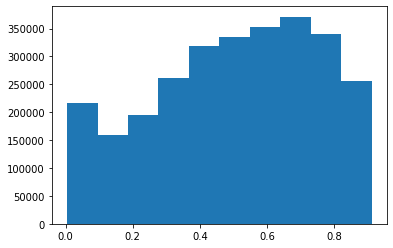

In [41]:
plt.hist(pred_ans)

In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets


In [107]:
data

,sa_id,album_id,label,view_no,buy_tot,buy_history_price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,i30_meta_price,movie_meta_price,pr_info,release_date,run_time
0,0,9174,1,0,0.000000,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
1,22,9174,1,1,0.014354,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
2,57,9174,1,1,0.004785,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
3,68,9174,1,1,0.038278,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
4,319,9174,1,1,0.004785,0.054945,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.051020,0.051020,3,0.988236,0.281167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28948275,1046745,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948276,1511615,10065,0,1,0.004785,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948277,18478,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650
28948278,931340,10065,0,0,0.000000,0.164835,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.202041,0.202041,3,0.998944,0.315650


In [111]:
user_uni_tab

,sa_id,view_no,buy_tot
0,0,0,0.000000
1,22,1,0.014354
2,57,1,0.004785
3,68,1,0.038278
4,319,1,0.004785
...,...,...,...
28785995,1401528,0,0.000000
28845606,786980,0,0.000000
28848954,1381118,0,0.000000
28858660,136643,0,0.000000


In [112]:
cont_uni_tab

,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,6,7,8,9,album_id,buy_history_price,i30_meta_price,label,movie_meta_price,pr_info,release_date,run_time
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9174,0.054945,0.051020,1,0.051020,3,0.988236,0.281167
30500,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11779,0.283516,0.202041,0,0.202041,2,0.999764,0.305040
31873,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4715,0.030769,0.028571,0,0.028571,4,0.952768,0.251989
33439,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11453,0.000000,0.000000,1,0.000000,3,0.999290,0.286472
88576,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3008,0.030769,0.028571,0,0.028571,4,0.940414,0.246684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28940999,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,187,0.000000,0.028571,0,0.028571,4,0.893786,0.358090
28942737,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7671,0.228571,0.365306,0,0.365306,2,0.976494,0.352785
28944348,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2639,0.000000,0.028571,0,0.028571,2,0.763913,0.294430
28945629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5100,0.000000,0.028571,0,0.028571,2,0.953127,0.257294
